In [1]:
using ChaosTools, DynamicalSystems, Plots, LinearAlgebra, Statistics

┌ Warning: C:\Users\DeadScholar\.julia\packages\Plots\qZHsp\src\Plots.jl\ is not an existing directory, Revise is not watching
└ @ Revise C:\Users\DeadScholar\.julia\packages\Revise\S7mrl\src\Revise.jl:489


Start by making test-case Tent map.

In [14]:
tent_eom(x, p, n) = (x < 0.4 ? 3x : 2(1-x))
tent_jacob(x, p, n) = (x < 0.4 ? 3 : -2)
tent = DiscreteDynamicalSystem(tent_eom, 0.2, nothing, tent_jacob)

1-dimensional discrete dynamical system
 state:       0.2
 e.o.m.:      tent_eom
 in-place?    false
 jacobian:    tent_jacob
 parameters:  nothing

Our goal is to get expansion entropy $H_0 = \log(2)$ for both systems.

We start with replicating Fig. 2 of the paper. Using the tent-map, with confinement set $S = [0, 1]$. Sample $N=1000$ points in $S$, and iterate them up to $T = 40$.

In [16]:
"""
Calculates the maximal expansion rate of M among all possible subspaces, that is, the 
product of all singular values of M that are greater than 1.
"""
maximalexpansion(M) = prod(filter(x -> x>1.0, svdvals(M)))

@assert maximalexpansion([1. 0. 0. 0. 2.; 0. 0. 3. 0. 0.; 0. 0. 0. 0. 0.; 0. 2. 0. 0. 0.]) == 3.0 * 2.23606797749979 * 2.0
@assert maximalexpansion([1 0; 0 1]) == 1

In [24]:
function ottentropysample(system, samplegenerator, insidechecker; N=1000, Tmax=20)
    dim = dimension(system)
    eom = system.f
    p = system.p
    jacob = system.jacobian
    
    samples = samplegenerator(N)
    jacobians = fill(Matrix{Float64}(I, dim, dim), N)
    inside = fill(true, N)
    
    for t in 1:Tmax
        for (i, point) in enumerate(samples)
            if inside[i]
                newpoint = eom(point, p, t)
                if insidechecker(newpoint)
                    samples[i] = newpoint
                    jacobians[i] *= jacob(point, p, t)
                else
                    inside[i] = false
                end
            end
        end
    end
    return log( sum(maximalexpansion.(jacobians[inside])) / N )
end

ottentropysample (generic function with 1 method)

In [38]:
function ottentropygraph(system, samplegenerator, insidechecker; samplenumber=100, Tmax=40, N=1000)
    meanlist = zeros(Tmax)
    stdlist = zeros(Tmax)
    entropysamples = zeros(samplenumber)

    for Tmax in 1:Tmax
        entropysamples = []
        for i in 1:samplenumber
            ent = ottentropysample(system, samplegenerator, insidechecker; N=N, Tmax=Tmax)
            if ent > -Inf
                push!(entropysamples, ent)
            end
        end
        if length(entropysamples) ≤ 1
            println("Warning: Insufficient sample. Consider increasing sample number.")
            entropysamples = [0, 0]
        end
        meanlist[Tmax] = mean(entropysamples)
        stdlist[Tmax] = std(entropysamples)
    end
    return meanlist, stdlist
end

ottentropygraph (generic function with 1 method)

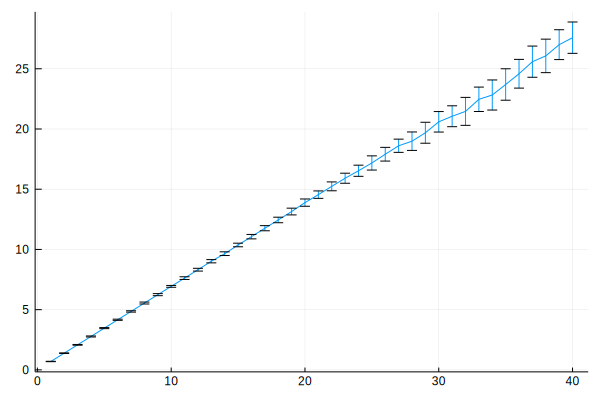

In [27]:
meanlist, stdlist = ottentropygraph(tent, rand, x -> 0 < x < 1; samplenumber=100, Tmax=40, N=1000)
plot(meanlist, yerr=stdlist, leg=false)

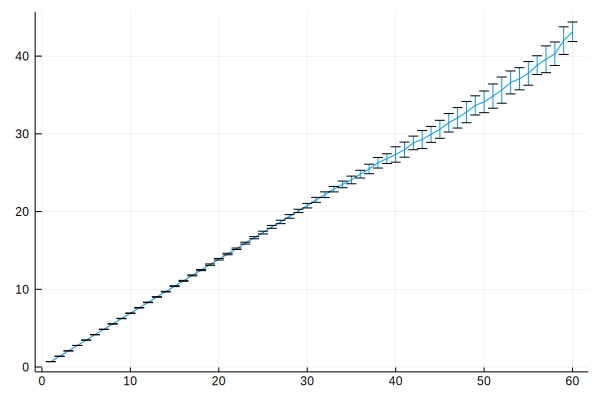

In [157]:
meanlist, stdlist = ottentropygraph(rand, x -> 0 < x < 1; samplenumber=100, Tmax=60, N=10000)
plot(meanlist, yerr=stdlist, leg=false)

In [161]:
println("The numerical expansion entropy of the tent map is ", (meanlist[30]-meanlist[1])/(30-1))
println("The theoretical result is ", log(2))

The numerical expansion entropy of the tent map is 0.6919717003990014
The theoretical result is 0.6931471805599453


Thus, we have reproduced figure 1 and 2 of Ott's paper, as well as recovered 

Now we reproduce figure 4.

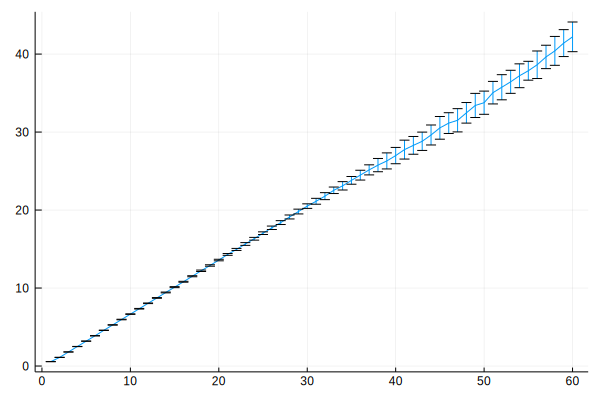

In [167]:
sampler(n) = rand(n) .* 2.5 .-1.0
meanlist, stdlist = ottentropygraph(sampler, x -> -1 < x < 1.5; samplenumber=100, Tmax=60, N=10000)
plot(meanlist, yerr=stdlist, leg=false)

In [168]:
println("The numerical expansion entropy of the tent map is ", (meanlist[30]-meanlist[1])/(30-1))
println("The theoretical result is ", log(2))

The numerical expansion entropy of the tent map is 0.6876729567688611
The theoretical result is 0.6931471805599453


Now we reproduce the result for the Henon map in fig 7.

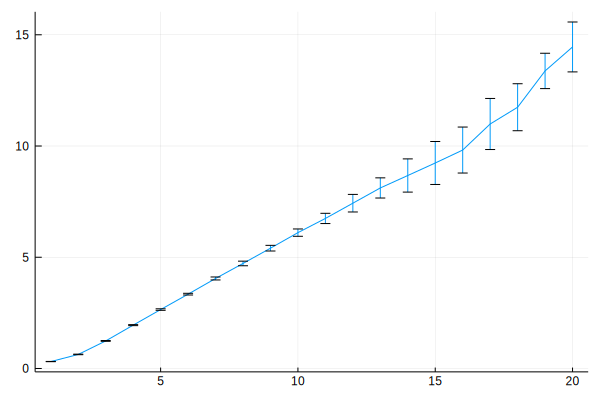

In [37]:
henon = Systems.henon(a=4.2, b=0.3)

function samplegenerator(n::Int)
    samples = Array{Array{Float64}}(undef, n)
    for i in 1:n
        samples[i] = rand(2).*6 .- 3
    end
    return samples
end
insidechecker(x) = -3<x[1]<3 &&  -3<x[2]<3

meanlist, stdlist = ottentropygraph(henon, samplegenerator, insidechecker; samplenumber=100, Tmax=20, N=100000)
plot(meanlist, yerr=stdlist, leg=false)

Let's fit the $\log(2)$ line to it:

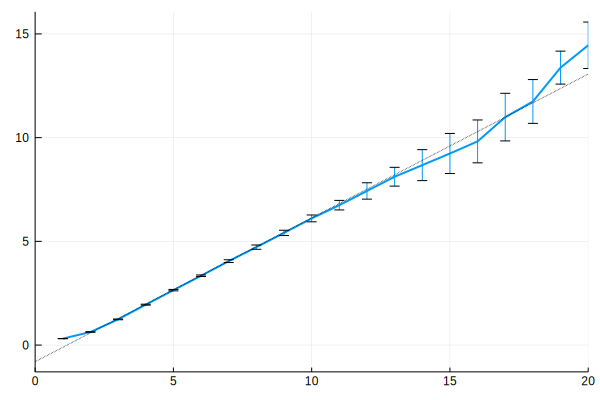

In [48]:
plot(meanlist, yerr=stdlist, linewidth=2, leg=false)
plot!(x->log(2)x-0.8, xlims=(0, 20), color=:black, linestyle=:dot, leg=false)